In [120]:
from torch.nn import ReLU,Module
from torch.nn import functional as F
import torch
import torch.nn as nn

In [121]:
class RestNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(RestNetBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        output = self.conv1(x)
        output = F.relu(self.bn1(output))
        output = self.conv2(output)
        output = self.bn2(output)
        return F.relu(x + output)

In [122]:
class RestNetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(RestNetDownBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride[0], padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride[1], padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.extra = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride[0], padding=0),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        extra_x = self.extra(x)
        output = self.conv1(x)
        out = F.relu(self.bn1(output))

        out = self.conv2(out)
        out = self.bn2(out)
        return F.relu(extra_x + out)

In [123]:
class RestNet18(nn.Module):
    def __init__(self):
        super(RestNet18, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(RestNetBasicBlock(64, 64, 1),
                                    RestNetBasicBlock(64, 64, 1))

        self.layer2 = nn.Sequential(RestNetDownBlock(64, 128, [2, 1]),
                                    RestNetBasicBlock(128, 128, 1))

        self.layer3 = nn.Sequential(RestNetDownBlock(128, 256, [2, 1]),
                                    RestNetBasicBlock(256, 256, 1))

        self.layer4 = nn.Sequential(RestNetDownBlock(256, 512, [2, 1]),
                                    RestNetBasicBlock(512, 512, 1))

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.Linear(512, 1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(x.shape[0], -1)
        out = self.fc(out)
        return out


In [124]:
class RepresentationTransformation(nn.Module):
    def __init__(self, num_features=32, num_bins=21, num_classes=1):
        super(RepresentationTransformation, self).__init__()

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(100, 64),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out = self.fc(x)

        return out

In [125]:
class model(Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = RestNet18()
        # The dataset is too simple to use DistributionPoolingFilter in the paper, here I simply use the ReLU function as a filter
        self.filter = ReLU()
        self.linear = RepresentationTransformation()
        print(self.features)

    def forward(self,x):
        x = self.features(x)
        x = torch.reshape(x,[1,-1,1])
        x = self.filter(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

## This class is for loading datasets

In [126]:
import torchvision
from torch.utils.data import DataLoader,Dataset
import os
import numpy as np
from PIL import Image

In [127]:
class Mnist_Dataset(Dataset):

    def __init__(self,root_dir,train=False,transform=None) :

        self.root_dir = root_dir
        if train:
            img_0_path = os.path.join(self.root_dir,'mnist_train/0')
            img_0_path_str = self.root_dir + '/mnist_train/0/'
            img_7_path = os.path.join(self.root_dir,'mnist_train/7')
            img_7_path_str = self.root_dir + '/mnist_train/7/'
        else:
            img_0_path = os.path.join(self.root_dir, 'mnist_test/0')
            img_0_path_str = self.root_dir + '/mnist_test/0/'
            img_7_path = os.path.join(self.root_dir, 'mnist_test/7')
            img_7_path_str = self.root_dir + '/mnist_test/7/'
        # Get a list of image names in the folder
        img_0_list = os.listdir(img_0_path)
        img_7_list = os.listdir(img_7_path)
        len_0 = len(img_0_list)
        len_7 = len(img_7_list)
        for i in range(len_0):
            # Form the full relative path for easy access
            img_0_list[i] = img_0_path_str + img_0_list[i]
        for j in range(len_7):
            img_7_list[j] = img_7_path_str + img_7_list[j]
        self.transform = transform
        # Construct the label corresponding to the picture, where the label 0 corresponding to picture 0 and the label 1 corresponding to picture 1
        label_0_list = [0 for i in range(len_0)]
        label_7_list = [1 for i in range(len_7)]

        self.img_list = img_0_list + img_7_list
        self.label_list = label_0_list + label_7_list

        # Correspondingly shuffles the two arrays so that random and constant cancer purity samples are generated
        state = np.random.get_state()
        np.random.shuffle(self.img_list)
        np.random.set_state(state)
        np.random.shuffle(self.label_list)
    
    # This method accesses the corresponding image and label by index
    def __getitem__(self, index) :
        img_path = self.img_list[index]
        label = self.label_list[index]
        img = Image.open(img_path)
        # img = img/255.0
        img = self.transform(img)
        # img = torch.reshape(img,[3,224,224])
        return img,label
    
    # This method calculates the length of the dataset
    def __len__(self):
        assert len(self.img_list) == len(self.label_list)
        return len(self.img_list)



In [128]:
root_dir = './dataset'
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor(),
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
# get the train dataset
train_dataset = Mnist_Dataset(root_dir,True,transforms)
# get the test dataset
test_dataset = Mnist_Dataset(root_dir,False,transforms)

# a bag is 100, and in this example ,it can be regard as batch size
bag = 100
# load a bag of images from the dataset
train_dataloader = DataLoader(train_dataset,bag)
test_dataloader = DataLoader(test_dataset,bag)

## Training

In [129]:
import torch
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [130]:
num_epochs = 40

train_loss_ls = []

model = model().cuda()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)

for epoch in range(num_epochs):
    print('############## EPOCH - {} ##############'.format(epoch +1))
    training_loss = 0
    validation_loss = 0

    # train for one epoch
    print('******** training ********')

    num_predictions = 0

    pbar = tqdm(total=len(train_dataloader))

    model.train()
    for images, targets in train_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # If the size does not meet a package, skip it directly
        if len(images) != 100:
            continue

        # forward + backward + optimize
        y_logits = model(images)
        targets = float(sum(targets)) / float(len(targets))

        loss = abs(y_logits-targets)
        loss.backward()
        optimizer.step()

        # Accumulate the loss value in an epoch
        training_loss += loss.item()

        num_predictions += 100

        pbar.update(1)

    # training_loss /= num_predictions
    train_loss_ls.append(training_loss)
    print('Loss：',training_loss)
    if epoch == 30:
        torch.save(model.state_dict(), 'MIL_model.pth')
        print('Model had been saved')

    pbar.close()


  2%|▏         | 3/122 [00:00<00:05, 23.12it/s]

RestNet18(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): RestNetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): RestNetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentu


 99%|█████████▉| 121/122 [00:04<00:00, 26.78it/s]

  2%|▏         | 3/122 [00:00<00:04, 27.38it/s]

Loss： 55.89402332901955
############## EPOCH - 2 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.94it/s]

  2%|▏         | 3/122 [00:00<00:04, 27.26it/s]

Loss： 51.22401970624924
############## EPOCH - 3 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.86it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.96it/s]

Loss： 45.2317528873682
############## EPOCH - 4 ##############
******** training ********



 99%|█████████▉| 121/122 [00:05<00:00, 22.87it/s]

  2%|▏         | 2/122 [00:00<00:07, 15.62it/s]

Loss： 40.46976312994957
############## EPOCH - 5 ##############
******** training ********



 99%|█████████▉| 121/122 [00:06<00:00, 18.18it/s]

  2%|▏         | 2/122 [00:00<00:06, 17.31it/s]

Loss： 34.114626094698906
############## EPOCH - 6 ##############
******** training ********



 99%|█████████▉| 121/122 [00:05<00:00, 24.02it/s]

  2%|▏         | 3/122 [00:00<00:04, 27.00it/s]

Loss： 28.62514854967594
############## EPOCH - 7 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 25.95it/s]

  2%|▏         | 3/122 [00:00<00:04, 24.39it/s]

Loss： 22.657543897628784
############## EPOCH - 8 ##############
******** training ********



 99%|█████████▉| 121/122 [00:06<00:00, 18.98it/s]

  2%|▏         | 2/122 [00:00<00:06, 17.40it/s]

Loss： 16.198949709534645
############## EPOCH - 9 ##############
******** training ********



 99%|█████████▉| 121/122 [00:07<00:00, 17.27it/s]

  2%|▏         | 2/122 [00:00<00:07, 15.20it/s]

Loss： 12.173125088214874
############## EPOCH - 10 ##############
******** training ********



 99%|█████████▉| 121/122 [00:07<00:00, 17.10it/s]

  2%|▏         | 2/122 [00:00<00:06, 18.54it/s]

Loss： 10.18814268708229
############## EPOCH - 11 ##############
******** training ********



 99%|█████████▉| 121/122 [00:06<00:00, 18.58it/s]

  2%|▏         | 2/122 [00:00<00:07, 15.14it/s]

Loss： 10.636132389307022
############## EPOCH - 12 ##############
******** training ********



 99%|█████████▉| 121/122 [00:05<00:00, 23.44it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.43it/s]

Loss： 9.074532806873322
############## EPOCH - 13 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.12it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.60it/s]

Loss： 9.730806320905685
############## EPOCH - 14 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.30it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.65it/s]

Loss： 8.339707046747208
############## EPOCH - 15 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.31it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.92it/s]

Loss： 8.289965063333511
############## EPOCH - 16 ##############
hello
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.41it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.66it/s]

Loss： 8.580014199018478
############## EPOCH - 17 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.36it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.80it/s]

Loss： 9.67352294921875
############## EPOCH - 18 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.41it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.57it/s]

Loss： 9.360626369714737
############## EPOCH - 19 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.44it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.72it/s]

Loss： 9.592116713523865
############## EPOCH - 20 ##############
******** training ********



 99%|█████████▉| 121/122 [00:05<00:00, 22.47it/s]

  2%|▏         | 2/122 [00:00<00:07, 16.06it/s]

Loss： 9.213111519813538
############## EPOCH - 21 ##############
******** training ********



 99%|█████████▉| 121/122 [00:07<00:00, 17.28it/s]

  2%|▏         | 2/122 [00:00<00:07, 15.67it/s]

Loss： 10.028861552476883
############## EPOCH - 22 ##############
******** training ********



 99%|█████████▉| 121/122 [00:07<00:00, 17.01it/s]

  2%|▏         | 2/122 [00:00<00:06, 19.05it/s]

Loss： 9.64546349644661
############## EPOCH - 23 ##############
******** training ********



 99%|█████████▉| 121/122 [00:06<00:00, 17.34it/s]

  2%|▏         | 2/122 [00:00<00:07, 15.52it/s]

Loss： 9.363881409168243
############## EPOCH - 24 ##############
******** training ********



 99%|█████████▉| 121/122 [00:06<00:00, 19.99it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.73it/s]

Loss： 9.030203074216843
############## EPOCH - 25 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.38it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.54it/s]

Loss： 9.765665650367737
############## EPOCH - 26 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.42it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.74it/s]

Loss： 8.47634044289589
############## EPOCH - 27 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.39it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.30it/s]

Loss： 8.475271970033646
############## EPOCH - 28 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.40it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.63it/s]

Loss： 9.140861511230469
############## EPOCH - 29 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.43it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.66it/s]

Loss： 9.031520247459412
############## EPOCH - 30 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.42it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.92it/s]

Loss： 8.658428937196732
############## EPOCH - 31 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.05it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.72it/s]

Loss： 8.59256511926651
Model had been saved
############## EPOCH - 32 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.28it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.39it/s]

Loss： 8.970851570367813
############## EPOCH - 33 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.29it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.17it/s]

Loss： 7.9852612018585205
############## EPOCH - 34 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.14it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.41it/s]

Loss： 8.305583417415619
############## EPOCH - 35 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.13it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.41it/s]

Loss： 7.936077386140823
############## EPOCH - 36 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.15it/s]

  2%|▏         | 3/122 [00:00<00:04, 26.51it/s]

Loss： 7.953366070985794
############## EPOCH - 37 ##############
******** training ********



 99%|█████████▉| 121/122 [00:04<00:00, 26.00it/s]

  2%|▏         | 3/122 [00:00<00:04, 24.64it/s]

Loss： 8.398583263158798
############## EPOCH - 38 ##############
******** training ********



 99%|█████████▉| 121/122 [00:05<00:00, 20.85it/s]

  2%|▏         | 2/122 [00:00<00:08, 14.96it/s]

Loss： 8.90810912847519
############## EPOCH - 39 ##############
******** training ********



 99%|█████████▉| 121/122 [00:06<00:00, 17.80it/s]

  2%|▏         | 2/122 [00:00<00:07, 15.29it/s]

Loss： 8.15978342294693
############## EPOCH - 40 ##############
******** training ********



 99%|█████████▉| 121/122 [00:06<00:00, 17.57it/s]

Loss： 8.983213484287262


In [131]:

model.eval()
predict_ls = [0.2]
true_ls = [0.2]
with torch.no_grad():

    for images,targets in test_dataloader:
        images = images.to(device)
        targets = targets.to(device)
        if len(images) != 100:
            continue
        y_logits = model(images)
        targets = float(sum(targets)) / float(len(targets))
        predict_ls.append(y_logits)
        true_ls.append(targets)

predict_ls.append(0.8)
true_ls.append(0.8)


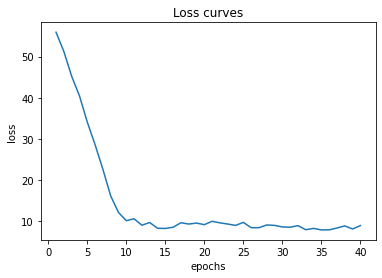

In [132]:
x = np.arange(1,len(train_loss_ls)+1)
plt.title("Loss curves")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(x,train_loss_ls)
plt.show()

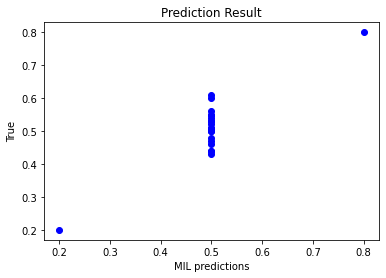

In [133]:
plt.title("Prediction Result")
plt.xlabel("MIL predictions")
plt.ylabel("True")
plt.plot(predict_ls,true_ls,"ob")
plt.show()